In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE


pi = np.pi

MSME = 332948.6                            # (M_sun/M_earth)


RNRE = 3.8647      # (Rnep/Rearth)
RJRE = 10.973      # (Rjup/Rearth)
RSRE = 109.2       # (Rsun/Rearth)

RSRN = RSRE/RNRE   # (Rsun/Rnep)
RSRJ = RSRE/RJRE   # (Rsun/Rjup)

BIGG = 6.67e-11    # Newton's constant [SI units]

RSUN = 6.957e8     # solar radius [m]
MSUN = 1.988e30    # Solar mass [kg]

GSUN = BIGG / RSUN**3 * MSUN * (24*3600)**2    # Newton's constant [R_sun^3 * M_sun^-1 * days^-2]

In [2]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

# Read in CKS data

In [3]:
# READ IN CKS DATABASE
# documentation of csv file found at http://www.astro.caltech.edu/~howard/cks/column-definitions.txt

cks_file = '/Users/research/projects/maiasaurus/catalogues/clean_kepler_catalogue.csv'

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

In [4]:
# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname']    = getkey('id_starname')             # star id - 'K00082'
d['koi']         = getkey('id_koicand')
d['kic']         = getkey('id_kic')                  # Kepler Input Catalogue ID
d['disposition'] = getkey('koi_disposition')         # status - 'CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', etc.
d['falsepos']    = getkey('cks_fp')                  # CKS false positive designation - 'False' or 'True'
d['snr']         = getkey('koi_model_snr')           # transit signal-to-noise
d['npl']         = getkey('koi_count')               # number of planets in system

d['period']      = getkey('koi_period')              # period (days)
d['period_err1'] = getkey('koi_period_err1')
d['period_err2'] = getkey('koi_period_err2')

d['rprs']      = getkey('koi_ror')                   # planet-to-star radius ratio
d['rprs_err1'] = getkey('koi_ror_err1')
d['rprs_err2'] = getkey('koi_ror_err2')

d['impact']      = getkey('koi_impact')              # impact parameter
d['impact_err1'] = getkey('koi_impact_err1')
d['impact_err2'] = getkey('koi_impact_err2')

d['koi_duration']      = getkey('koi_duration')      # transit duration (hours)
d['koi_duration_err1'] = getkey('koi_duration_err1')
d['koi_duration_err2'] = getkey('koi_duration_err2')

d['rp']      = getkey('iso_prad')                    # CKS+isochrone constrained planet radius (earth radius)
d['rp_err1'] = getkey('iso_prad_err1')
d['rp_err2'] = getkey('iso_prad_err2')

d['sma']      = getkey('iso_sma')                    # CKS+isochrone constrained semi-major axis (AU)
d['sma_err1'] = getkey('iso_sma_err1')
d['sma_err2'] = getkey('iso_sma_err2')

d['rstar']      = getkey('iso_srad')                 # CKS+isochrone constrained stellar radius (solar radius)
d['rstar_err1'] = getkey('iso_srad_err1')
d['rstar_err2'] = getkey('iso_srad_err2')

d['mstar']      = getkey('iso_smass')                # CKS+isochrone constrained stellar mas (solar mass)
d['mstar_err1'] = getkey('iso_smass_err1')
d['mstar_err2'] = getkey('iso_smass_err2')

d0 = d.copy()

In [5]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

total number of queried objects = 864
after removing missing data, number of objects = 864


In [6]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

# Apply cuts to CKS data to match SysSim

In [7]:
# first remove long period planets (P > 300)
keep = (d['period'] <= 300.)

for k in d.keys():
    d[k] = d[k][keep]
    
print('%d long-period planets (P > 300d) discarded to match SysSim limit' %np.sum(~keep))

5 long-period planets (P > 300d) discarded to match SysSim limit


In [8]:
# next remove small planets (R < 0.5)
keep = (d['rp'] >= 0.5)

for k in d.keys():
    d[k] = d[k][keep]
    
print('%d small planets (rp/Re < 0.5) discarded to match SysSim limit' %np.sum(~keep))

3 small planets (rp/Re < 0.5) discarded to match SysSim limit


In [9]:
# update number of planets in each system to reflect removals
uniquesys = np.unique(d['starname'])

for us in uniquesys:
    d['npl'][d['starname']==us] = int(np.sum(d['starname']==us))

    
# remove systems reduced to just one planet
npl = d['npl'].copy()

for k in d.keys():
    d[k] = d[k][npl > 1]
    
print('%d systems removed after being reduced to 1 planet' %np.sum(npl<=1))

1 systems removed after being reduced to 1 planet


In [10]:
# finally elimnate SYSTEMS which do not match period (P > 3) or radius (R < 10) limits
bad_planet = (d['rp'] > 10.0) + (d['period'] < 3.0)
bad_system = np.zeros_like(bad_planet)


uniquesys = np.unique(d['starname'])

for us in uniquesys:
    bad_system[d['starname']==us] = int(np.sum(bad_planet[d['starname']==us]))

for k in d.keys():
    d[k] = d[k][~bad_system]
    
print('%d systems discarded to match SysSim limits' %(len(uniquesys)-len(np.unique(d['starname']))))

69 systems discarded to match SysSim limits


# Calculate compexity metrics for each CKS system

In [11]:
uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    s.Rstar   = d['rstar'][d['starname']==us][0]
    
    # pull planetary data
    s.rprs    = d['rprs'][d['starname']==us]
    s.periods = d['period'][d['starname']==us]
    
    # sort periods and durations by period
    order = np.argsort(s.periods)
    
    s.rprs    = s.rprs[order]
    s.periods = s.periods[order]
    
    
    # calculate complexity measures (N, mu, Q, M, S, C, f)
    s.N  = len(s.rprs)
    s.M  = archinfo.M(s.periods, s.rprs)
    
    systems.append(s)

In [12]:
Nsys = len(uniquesys)

N  = np.zeros(Nsys)
M  = np.zeros(Nsys)


for i, s in enumerate(systems):
    N[i]  = s.N
    M[i]  = s.M

# Read in SysSim data

In [13]:
# READ IN SYSSIM DATABASE
syssim_file = '/Users/research/Desktop/dinosaur/ExoJulia/SysSimExClusters/trials/observed_catalog_01.csv'

syssim_data = []
with open(syssim_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        syssim_data.append(row)
        
KEYS = syssim_data[20]
VALUES = syssim_data[21:]

def getkey(keyname,keys=KEYS,values=VALUES, convert_to_float=True):
    '''
    keyname = (string) of column definition
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
        
    if convert_to_float:
        return np.array(dummy, dtype='float')
    else:   
        return np.array(dummy)

In [14]:
# PULL RELEVANT QUANTITIES FROM CATALOGUE
syssim = {}

syssim['star_id'] = np.array(getkey('star_id'), dtype='int')
syssim['target_id'] = np.array(getkey('target_id'), dtype='int')

syssim['period'] = getkey('period')
syssim['depth']  = getkey('depth')
syssim['tdur']   = getkey('duration')

syssim['rstar']   = getkey('star_radius')
syssim['mstar']   = getkey('star_mass')
syssim['rhostar'] = syssim['mstar']/syssim['rstar']**3

syssim['rprs'] = np.sqrt(syssim['depth'])
syssim['rp']   = syssim['rprs']*syssim['rstar']*RSRE

In [15]:
# determine number of planets per system
star_id = np.array(syssim['star_id'], dtype='float')

# count up the planets in each system
syssim_npl = np.zeros_like(star_id, dtype='int')

for i, sid in enumerate(star_id):
    syssim_npl[i] = np.sum(star_id == sid)
    
syssim['npl'] = syssim_npl

# remove single-planet systems
for k in syssim.keys():
    syssim[k] = syssim[k][syssim_npl > 1]

# Apply limit cuts to SysSim data

In [16]:
# first remove long period planets (P > 400)
keep = (syssim['period'] <= 300.)

for k in syssim.keys():
    syssim[k] = syssim[k][keep]
    
print('%d long-period planets (P > 300d) discarded' %np.sum(~keep))

0 long-period planets (P > 300d) discarded


In [17]:
# next remove small planets (R < 0.5)
keep = (syssim['rp'] >= 0.5)

for k in syssim.keys():
    syssim[k] = syssim[k][keep]
    
print('%d small planets (rp/Re < 0.5) discarded' %np.sum(~keep))

0 small planets (rp/Re < 0.5) discarded


In [18]:
# update number of planets in each system to reflect removals
syssim_uniquesys = np.unique(syssim['star_id'])

for us in syssim_uniquesys:
    syssim['npl'][syssim['star_id']==us] = int(np.sum(syssim['star_id']==us))

    
# remove systems reduced to just one planet
syssim_npl = syssim['npl'].copy()

for k in syssim.keys():
    syssim[k] = syssim[k][syssim_npl > 1]
    
print('%d systems removed after being reduced to 1 planet' %np.sum(syssim_npl<=1))

0 systems removed after being reduced to 1 planet


In [19]:
# finally elimnate SYSTEMS which do not match period (P > 3) or radius (R < 10) limits
bad_planet = (syssim['rp'] > 10.0) + (syssim['period'] < 3.0)
bad_system = np.zeros_like(bad_planet)


syssim_uniquesys = np.unique(syssim['star_id'])

for us in syssim_uniquesys:
    bad_system[syssim['star_id']==us] = int(np.sum(bad_planet[syssim['star_id']==us]))

for k in syssim.keys():
    syssim[k] = syssim[k][~bad_system]
    
print('%d systems discarded' %(len(syssim_uniquesys)-len(np.unique(syssim['star_id']))))

0 systems discarded


# Calculate complexity metrics for SysSim systems

In [20]:
# determine number of planets per system
star_id = np.array(syssim['star_id'], dtype='float')

# count up the planets in each system
syssim_npl = np.zeros_like(star_id, dtype='int')

for i, sid in enumerate(star_id):
    syssim_npl[i] = np.sum(star_id == sid)
    
syssim['npl'] = syssim_npl

# remove single-planet systems
for k in syssim.keys():
    syssim[k] = syssim[k][syssim_npl > 1]

In [21]:
# calculate system-level measures

syssim_uniquesys = np.unique(syssim['star_id'])
syssim_systems   = []

for us in syssim_uniquesys:   
    # initialize System() object
    s = System()
    
    # pull stellar data
    s.sysid   = us
    s.Mstar   = syssim['mstar'][syssim['star_id']==us][0]
    s.Rstar   = syssim['rstar'][syssim['star_id']==us][0]
    
    # pull planetary data
    s.rprs    = syssim['rp'][syssim['star_id']==us]/RSRE
    s.periods = syssim['period'][syssim['star_id']==us]

    # sort masses, periods, and durations by period
    order = np.argsort(s.periods)
    
    s.rprs    = s.rprs[order]
    s.periods = s.periods[order]
    
    # calculate complexity measures (N, mu, Q, M, S, C, f)
    s.N  = len(s.rprs)
    s.M  = archinfo.M(s.periods, s.rprs)
    
    syssim_systems.append(s)

In [22]:
syssim_Nsys = len(syssim_uniquesys)

syssim_N  = np.zeros(syssim_Nsys)
syssim_M  = np.zeros(syssim_Nsys)

for i, s in enumerate(syssim_systems):
    syssim_N[i]  = s.N
    syssim_M[i]  = s.M

# Now plot them together

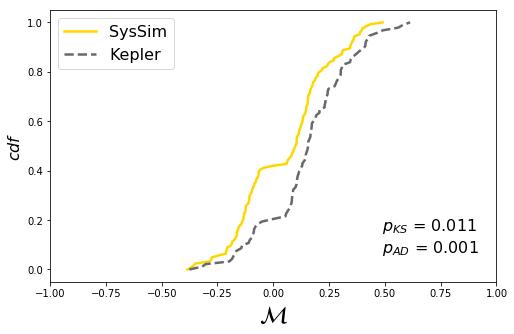

In [23]:
pKS_M = stats.ks_2samp(M[N>2], syssim_M[syssim_N>2])[1]
pKS_N = stats.ks_2samp(N[N>2], syssim_N[syssim_N>2])[1]

pAD_M = stats.anderson_ksamp([M[N>2],syssim_M[syssim_N>2]])[2]
pAD_N = stats.anderson_ksamp([N[N>2],syssim_N[syssim_N>2]])[2]


plt.figure(figsize=(8,5))


plt.plot(np.sort(syssim_M[syssim_N>2]), np.linspace(0,1,len(syssim_M[syssim_N>2])), c='gold', lw=2.5, label='SysSim')
plt.plot(np.sort(M[N>2]), np.linspace(0,1,len(M[N>2])), c='dimgrey', lw=2.5, ls='--', label='Kepler')
plt.xlabel(r'$\mathcal{M}$', fontsize=24)
plt.ylabel(r'$cdf$', fontsize=16)
plt.xlim(-1,1)
plt.text(0.92, 0.05, '$p_{KS}$ = %.3f \n$p_{AD}$ = %.3f' %(pKS_M, pAD_M), fontsize=16, ha='right', va='bottom')
plt.legend(loc='upper left', fontsize=16)
plt.show()

In [24]:
np.sum(syssim_M[syssim_N>2] < 0)/len(syssim_M[syssim_N>2])

0.416

In [25]:
(416+387+442+411+403+421+409+492+472+397)/10

425.0